In [1]:
# ! pip install ipywidgets
# ! pip install ipympl
# !jupyter labextension list
# %matplotlib widget

# Rotations

**Convention 1**: A positive rotation, about the z-axis, in a Right Handed Coordinate frame is defined as a rotation where the x-axis moves towards the y-axis

Corrolarys:

1. A positive rotation, is CCW when you are looking from the +ve zed axis, down onto the Z=0 plane.

2. A positive rotation, is CW when you are looking from the -ve zed axis, up onto the Z=0 plane.

3. A positive rotation, causes the X-axis to rotate towards the Y-axis

**Convention 2: X: North; Y: East, Z: Down a.k.a. NED**
- This is in contrast to another popular "ENU" coordinate frame.


**Things that invert polarity of rotations:**

A.  Coordinate Frame: If you switch between NED and ENU, the effect of the same rotation matrix on a vector, will push it in the opposite direction, when you look at the vector on a map. frame.

B. The sign of the rotation angle (+ve, vs -ve angle). 

C. Choice of similarity transform definition $R Z R^T$ vs $R^T Z R$ 

- We use $R Z R^T$ which is appropriate for the MT Equation formulation $E = ZH$
- Justification is provided below

D. Definition of Rotation Matrix

\begin{equation*}
R
= 
\begin{bmatrix} cos(\theta) & -sin(\theta)  \\ sin(\theta) & cos(\theta) \end{bmatrix} 
\label{eq:R} \tag{R}
\end{equation*}

Carefull not to define the rotation matrix as $R^T$, which is also a rotation matrix, and is the inverse of $R$, i.e. it rotates the other way.  

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# from scipy.spatial.transform import Rotation


##### Here are the cardinal points for the two conventions:

In [3]:
# NED: X:North, Y: East, Z: Down

reference_points = {}
reference_points["NED"] = {
    "north": np.array([1, 0]), 
    "east" : np.array([0, 1]),
    "south": np.array([-1, 0]), 
    "west" : np.array([0, -1]),
}

# ENU: X:East, Y: North, Z: Up
reference_points["ENU"] = {
    "north": np.array([0, 1]), 
    "east" : np.array([1, 0]),
    "south": np.array([0, -1]), 
    "west" : np.array([-1, 0]),
}


Define our rotation matrix R.  

_Careful, if this isn't correct things will go backwards._

In [4]:
def rotation_matrix(
    theta: float,
    conventional: bool = True
) -> np.ndarray:
    """
    Parameters
    theta: float
        Rotation angle in radians
    conventional: Optional[bool]
        Set to False to return R^-1 = R.T.  Just for this tutorial.
    """
    R = np.asarray(
        [
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)],
        ]
    )
    if conventional is False:
        R = R.T  # this was the problem in issue 57 mtpy

    # uncomment below to hide 1e-17 floating point stuffs when looking at tutorial
    R[np.abs(R) < 1e-15] = 0


    return R
    


In [5]:
theta = np.deg2rad(90)

### Sanity Check 1

According to convention 1, in a NED frame, R should rotate a vector pointing **North** towards the **East** (X towards Y).

In [6]:
theta = np.deg2rad(90)
R = rotation_matrix(theta, conventional=True)
R

array([[ 0., -1.],
       [ 1.,  0.]])

In [7]:
coordinate_frame = "NED"
initial_direction = "north"
result = R @ reference_points[coordinate_frame][initial_direction]

for direction,vector in reference_points[coordinate_frame].items():
    difference = np.abs(result-vector)
    if np.isclose(difference,0, atol=1e-10).all():
        print(f"{initial_direction} in {coordinate_frame} points {direction} after multiply by R")

north in NED points east after multiply by R


The sanity check passed, the north vector has been rotated to the east.

**This R matrix, is the rotation matrix that satisfies Conventions 1 and 2.**

### Sanity check 2:

- $R^T =  R^{-1}$
- In **ENU** R(90) will rotate North to the West

In [8]:
# R.T == R^(-1)
assert (R.T @ R == np.eye(2)).all()

Lets see the effect of this rotation matrix:

In [9]:
coordinate_frame = "ENU"
initial_direction = "north"
result = R @ reference_points[coordinate_frame][initial_direction]

for direction,vector in reference_points[coordinate_frame].items():
    difference = np.abs(result-vector)
    #print(direction, difference)
    if np.isclose(difference,0, atol=1e-10).all():
        print(f"{initial_direction} in {coordinate_frame} points {direction} after multiply")# by {R}")

north in ENU points west after multiply


Yup, thats right.

So the same rotation matrix rotates the vector in opposite directions depending on the coordinate system.

## Rotating the Impedance Tensor

Below is a cartoon to hopefully help motivate rotating the impedance tensor.

The coil, when laid out in the field, was rotated by 30 degrees


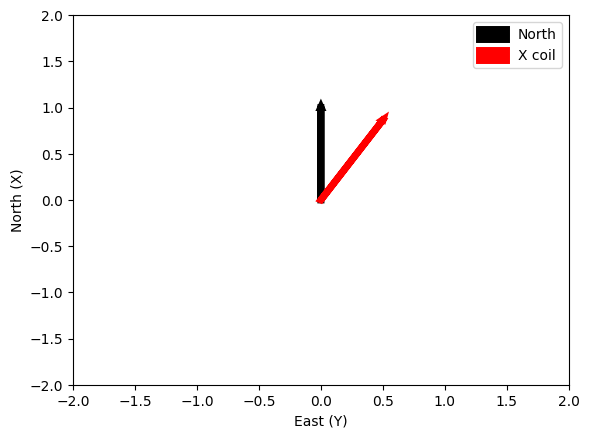

In [10]:
fig, ax = plt.subplots()

#np.array([0,0]), np.array([0,1]), color="black", linewidth=5) 

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel("East (Y)")
ax.set_ylabel("North (X)")

theta_coil_degrees = 30
print(f"The coil, when laid out in the field, was rotated by {theta_coil_degrees} degrees")
R_theta = rotation_matrix(np.deg2rad(theta_coil_degrees))
R_coil = R_theta @ reference_points["NED"]["north"]

# Careful when plotting here: we need to invert matplotlibs convention of X increasing left to right and Y increasing down-to-up
ax.arrow(0, 0, 0, 1,  color="black", linewidth=5, label="North") 
ax.arrow(0, 0, R_coil[1], R_coil[0],  color="red", linewidth=5, label="X coil") # normally you would pass ax.arrow(0, 0, R_coil[0], R_coil[1])
ax.legend()
plt.show()

Figure: The red arrow denotes the orientation of a coil in the field, the black arrow denotes north.  

The coil, when laid out was 30 degrees +ve rotated from North, so 

**The rotation matrix R, will be $R(-30)$ -- the matrix that maps the field coordinates back to Cardinal**.

_Another way to say it: The data that we acquired is what would have been measured if we had laid the sensors along the cardinal axes, and then applied a +30 degree rotation.  Thus, we need to apply -30 to get the cardinal data back._

Now that we are on solid ground rotating vectors, let's think about what we are doing when we rotate the impedance tensor.

**Assumption**: The data have been collected with an orthoganal layout.  If the sensors were not perpendicular when laid out in the field, an addition processing step _Orthogonalization_ is needed.  We assume this has already been carried out.

So we have data: $E_x, E_y, H_x, H_y$ that is associated with a Right Handed Coordinate System, with Z-down.

We need to rotate the data through some angle $\theta$ so that it is as if the sensors were oriented along the cardinal direction during acquistion.

**Caution**: The value of $\theta$ here is the value that rotates the E, H _**from**_ instrument coordinates _**to**_ NED.  It is easy to accidentally measure the angle from North, say, to your X-magnetometer and and call it $\theta$, but that is _negative_ theta.  See Figure above.


### Gory detail:

\begin{equation*}
\begin{bmatrix} E_x \\ E_y \end{bmatrix} 
= 
\begin{bmatrix} Z_{xx} & Z_{xy}  \\ Z_{yx} & Z_{yy} \end{bmatrix} 
\begin{bmatrix} H_x \\ H_y \end{bmatrix}
\label{eq:1} \tag{1}
\end{equation*}


Abbreviating:


\begin{equation*}
E = Z H
\label{eq:2} \tag{2}
\end{equation*}

We can accomplish this by rotating both $E$ and $H$ by $\theta$

Let $R_{\theta}$ denote the rotation matrix, that rotates $E, H$ vectors into the cardinal frame. Let $Z_c$ denote the Impedance tensor in the Cardinal Frame (Sensors oriented North and East).


Then

\begin{equation*}
R_{\theta} E = Z_c R_{\theta} H
\label{eq:3} \tag{3}
\end{equation*}

Multiply both sides of $\eqref{eq:3}$ by $R_{\theta}^T$ on the left.

\begin{equation*}
R_{\theta}^T R_{\theta} E = R_{\theta}^T Z_c R_{\theta} H
\label{eq:4} \tag{4}
\end{equation*}

Then note that the $R^TR$ on the LHS term above is the identity matrix so $\eqref{eq:4}$ reduces to:

\begin{equation*}
E = R_{\theta}^T Z_c R_{\theta} H
\label{eq:5} \tag{5}
\end{equation*}

Now substitute for $E$ on the LHS of $\eqref{eq:5}$, $ZH$ (By definition of $\eqref{eq:2}$)

\begin{equation*}
ZH = R_{\theta}^T Z_c R_{\theta} H
\label{eq:6} \tag{6}
\end{equation*}


By method of staring at $\eqref{eq:6}$, we see that it must be true that

\begin{equation*}
Z = R_{\theta}^T Z_c R_{\theta}
\label{eq:7} \tag{7}
\end{equation*}


Multiply both sides of $\eqref{eq:7}$ by $R_{\theta}$ on the left.

\begin{equation*}
R_{\theta} Z = R_{\theta} R_{\theta}^T Z_c R_{\theta}
\label{eq:8} \tag{8}
\end{equation*}

And replace $R_{\theta} R_{\theta}^T$ with the identity matrix:

\begin{equation*}
R_{\theta} Z = Z_c R_{\theta}
\label{eq:9} \tag{9}
\end{equation*}

Multiply both sides of $\eqref{eq:9}$ by $R_{\theta}^T$ on the right:

\begin{equation*}
R_{\theta} Z R_{\theta}^T = Z_c R_{\theta} R_{\theta}^T
\label{eq:10} \tag{10}
\end{equation*}


Once agin,  replace $R_{\theta} R_{\theta}^T$ with the identity matrix:

\begin{equation*}
R_{\theta} Z R_{\theta}^T = Z_c 
\label{eq:11} \tag{11}
\end{equation*}

At last, we see that the Cardinal Impedance Tensor $Z_c$ can be obtained from $Z$ (the impedance tensor computed in an othogonal, right-handed frame, rotated ) at some angle.







<div class="alert alert-block alert-info"> <b>NOTE</b> TLDR. </div>

- $Z_c = RZR^T$
- $Z = R^TZ_c R$

Where R is the Rotation Matrix which takes an E, H vector in the field-acquisition coordinate frame and rotates it to NED.


Note that
$RZR^T$ does not in general equal $R^TZR$ (although they are equal for 90 degrees).

# Electromagnetic Strike Angle

This is the angle of impedance tensor rotation at which the earth is maximally 2D, i.e. where the magnitude of the trace of $Z$ is minimal.

Here are some tools for sanity checking strike angle:

Assume we have the impedance tensor in Cardinal frame:

In [11]:
# TODO: get a more realistic Z tensor
Zc = np.asarray(
    [
        [0.3, complex(2,1)],
        [3, 4],
    ]
) 
Zc

array([[0.3+0.j, 2. +1.j],
       [3. +0.j, 4. +0.j]])

In [12]:
def rotate_field_to_cardinal(Z, theta):
    """
        Parameters
        ----------
        Z: np.ndarray
            This is an impedance tensor measured in an orthogonal, Right handed instrument coordinate frame
        theta: float
            This is the angle, in radians, by which the field Z must be rotated to align with the Cardinal frame (NED).
            It is therefore the opposite of the angle by which the deployed instruments were rotated from NED.
            
        Returns
        -------
        rotated: np.ndarray
            The value of the impedance tensor that would have been measured if the instruments were deployed in the Cardinal frame.
            
        Notes: 
        - The sensors were deployed rotated by _negative theta_.
        - Rotating by +ve theta means X-towards-Y (North-towards-East)
        - R (Rotation Matrix) maps E, H vectors in the field-acquisition coordinate frame to NED.

    """
    R = rotation_matrix(theta)
    rotated = R @ Z @ R.T
    return rotated
    

def rotate_cardinal_to_field(Zc, theta):
    """
    Parameters
        ----------
        Zc: np.ndarray
            This is an impedance tensor measured in the Cardinal (NED) frame.
        theta: float
            This is the angle, in radians, by which we rotate.  TODO: add intuitive statement here.
            
    Returns tensor that would have been observed if the sensors had been rotated through negative theta.

    R (Rotation Matrix) maps E, H vectors in the field-acquisition coordinate frame to NED.
    """
    return rotate_field_to_cardinal(Zc, -theta)
    

In [13]:
Zc

array([[0.3+0.j, 2. +1.j],
       [3. +0.j, 4. +0.j]])

In [14]:
theta_deg = 30.
theta = np.deg2rad(theta_deg)

In [15]:
Zf = rotate_cardinal_to_field(Zc, theta)
print(f"if the sensors had been deployed {-theta_deg} degrees, we would measure:")
Zf

if the sensors had been deployed -30.0 degrees, we would measure:


array([[3.39006351+0.4330127j, 2.352147  +0.75j     ],
       [3.352147  -0.25j     , 0.90993649-0.4330127j]])

In [16]:
print(f" To correct for that, we would rotate the field-coordinate tensor by {theta_deg}")
back_to_zc = rotate_field_to_cardinal(Zf, theta)
back_to_zc

 To correct for that, we would rotate the field-coordinate tensor by 30.0


array([[0.3-7.43708407e-18j, 2. +1.00000000e+00j],
       [3. -4.13026482e-18j, 4. -7.72033963e-18j]])

In [17]:
# So if we have Zc, 

In [18]:
def seek_strike_angle_in_1_deg_increments(Zc):
    """
    
    This function rotates the impedance tensor through positive angles theta from 0 to 360 degrees
    and computes the magnitude of the trace at each rotation.
    
    Recall that:
    - $Z_c = RZR^T$  Where R maps E, H vectors in the field-acquisition coordinate frame to NED.
    - $Z = R^TZ_c R$
    
    If the input tensor is Cardinally oriented
    
    Zc: np.ndarray
        This is a 2x2 impedance tensor in Cardinal coordinate frame
    """
    square_diag = np.zeros(360)
    for i in range(360):
        Z_field = rotate_cardinal_to_field(Zc, np.deg2rad(i))
        square_diag[i] = np.linalg.norm(np.diag(Z_field))

    return square_diag
    

In [19]:
initial_square_diag = seek_strike_angle_in_1_deg_increments(Zc)

In [20]:
i = 17
print(initial_square_diag[i])
print(initial_square_diag[i+1])
print(initial_square_diag[i+2])

3.072164962045454
3.069075988645593
3.073719228921057


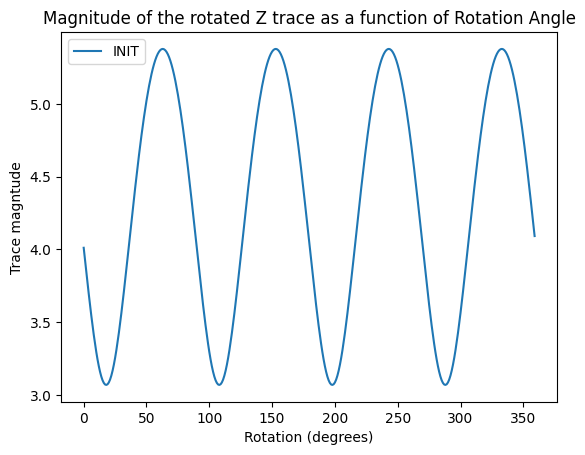

In [21]:
plt.plot(np.arange(360), initial_square_diag, label="INIT")
plt.xlabel("Rotation (degrees)")
plt.ylabel("Trace magntude")
plt.title("Magnitude of the rotated Z trace as a function of Rotation Angle")
plt.legend()
plt.show()

# Interpreation

- The x-axis values theta, correspond to "correcting for a field-deployment rotation of $\theta$" 
- Thus, when we see a minima above at around 18 degrees, because we used `rotate_cardinal_to_field`, the tensor at angle $\theta$ is what would have been observed if the sensors had been rotated through negative $\theta$.
- so if the system were rotated by -18 degrees in the field it would correspond to the first minima.
- Note the 90 degree ambiguity in strike angle (there are 4 minima, not 2:/)

- Say that we found out that our coordinate system was incorrect.

- In fact we need to rotate our sensors by an additional +13 degrees (X-tward-Y, North-toward-East)

- Then we can correct the impedance tensor, by effectively rotating our sensors by 13




In [22]:
repair_angle_deg = 13
repair_angle_rad = np.deg2rad(repair_angle_deg)
R_fix_csys = rotation_matrix(repair_angle_rad)
Zc_fixed =  R_fix_csys @ Zc @ R_fix_csys.T
Zc_fixed

array([[-0.60869685-0.21918557j,  0.93599849+0.94939702j],
       [ 1.93599849-0.05060298j,  4.90869685+0.21918557j]])

In [23]:
assert (Zc_fixed == rotate_field_to_cardinal(Zc, repair_angle_rad)).all()

In [24]:
square_diag_fixed = seek_strike_angle_in_1_deg_increments(Zc_fixed)

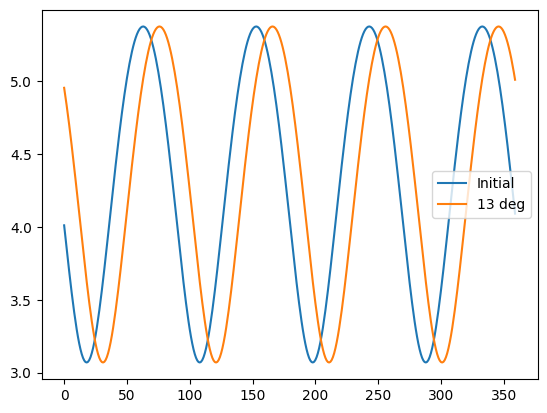

In [25]:
plt.plot(initial_square_diag, label="Initial")
plt.plot(square_diag_fixed, label=f"{repair_angle_deg} deg")
plt.legend()

In [26]:
# x1, x2: S1 S2
# x3, x4: D1 D2
# def simpson_strike(Z, alpha):
#     S1 = Z[0,0] + Z[1, 1]
#     S2 = Z[0,1] + Z[1, 0]
#     D1 = Z[0,0] - Z[1, 1]
#     S2 = Z[0,1] - Z[1, 0]
#     S2_prime = (S2 * np.cos(alpha)**2) - (D1 * np.sin(alpha)**2)
#     D1_prime = (D1* np.cos(alpha)**2) + (S2 * np.sin(alpha)**2)
    
#     numerator = 2*np.real()
#     fouralpha = np.arctan2()